## Is it an Anime?

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [2]:
import os
import requests
import re
import time
from fastai.vision.all import *

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Step 1: Download images of anime and cartoons

In [3]:
from fastbook import *
# create a function that will take an arbitrary search term and return a list of urls.
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # search_images_ddg comes from fastbook: https://github.com/fastai/fastbook/blob/master/utils.py#L45
    return search_images_ddg(term, max_images=max_images)

In [5]:
# check code is working
# urls = search_images_ddg('bird photos', max_images=1)
# urls[0]

In [4]:
from fastdownload import download_url
from time import sleep

def download_images_ddg(path_to_save, label, query, max_images=10):
    '''
    path_to_save: path to directory where data resides
    label: parent directory which refers to class 
    query: search terms to use 
    max_images: number of images to retrieve
    '''
    path = Path(path_to_save) # root folder
    dest = (path/label) # subfolder for corresponding class
    dest.mkdir(exist_ok=True, parents=True) # create directories if do not exist
    download_images(dest, urls=search_images(f'{query} photo', max_images=max_images))

    # Remove failed images
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)
    print(f"Number of failed images: {len(failed)}")
    print(f"Number of images retrieved: {max_images - len(failed)}")
    sleep(10)  # Pause between searches to avoid over-loading server   
    

def resize_images_helper(path):
    '''
    path: path to images (it should point to the subfolder that contains the actual images)
    '''
    resize_images(path, max_size=400, dest=path)

#### Download and store images

In [39]:
label = "anime"
# label = "cartoon"
path_to_save = "../data/train_anime_or_not"
query = "anime from the 90s"

# Uncomment to download images
# download_images_ddg(path_to_save, label, query, max_images=10)

#### Resize all images (squish) to the same size

In [50]:
dest_anime = Path(path_to_save,"anime")
dest_cartoon = Path(path_to_save,"cartoon")

# Uncomment to resize
# resize_images_helper(dest_anime)
# resize_images_helper(dest_cartoon)

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Check an random image

In [5]:
import numpy as np
import glob

Total number of images: 99
Img #:29. Path:../data/train_anime_or_not/anime/54d7573d-b657-4314-b30d-b5fbc2f4973b.jpg


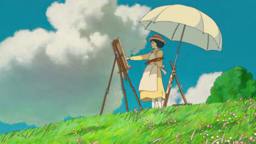

In [28]:
label = "anime"
# label = "cartoon"

path_to_imgs = f"../data/train_anime_or_not/{label}/*"

imgs = glob.glob(path_to_imgs) # retrieve all images
print(f"Total number of images: {len(imgs)}")
rand_int = np.random.randint(0, len(imgs)-1, size=1).item()
img = imgs[rand_int]
print(f"Img #:{rand_int}. Path:{img}")

im = Image.open(img) # open path to img
im.to_thumb(256,256)

## Step 2: Create Dataset Object

In [32]:
# Double check that failed images are deleted

path_to_all_imgs = "../data/train_anime_or_not/"

image_paths = get_image_files(path_to_all_imgs)
print(f"Total number of images: {len(image_paths)}")

failed = verify_images(image_paths)
failed.map(Path.unlink)
print(f"Total number of failed images: {len(failed)}")

Total number of images: 199
Total number of failed images: 0


#### Create a data loader object to store data

In [110]:
img_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # use 20% of images for validation
    get_y=parent_label, # class label comes from the name of the subfolder
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)], # resize images to 128x128 by default (crop) them
    batch_tfms=aug_transforms()
)

In [111]:
dls = img_data.dataloaders(path_to_all_imgs, bs=16)

Train


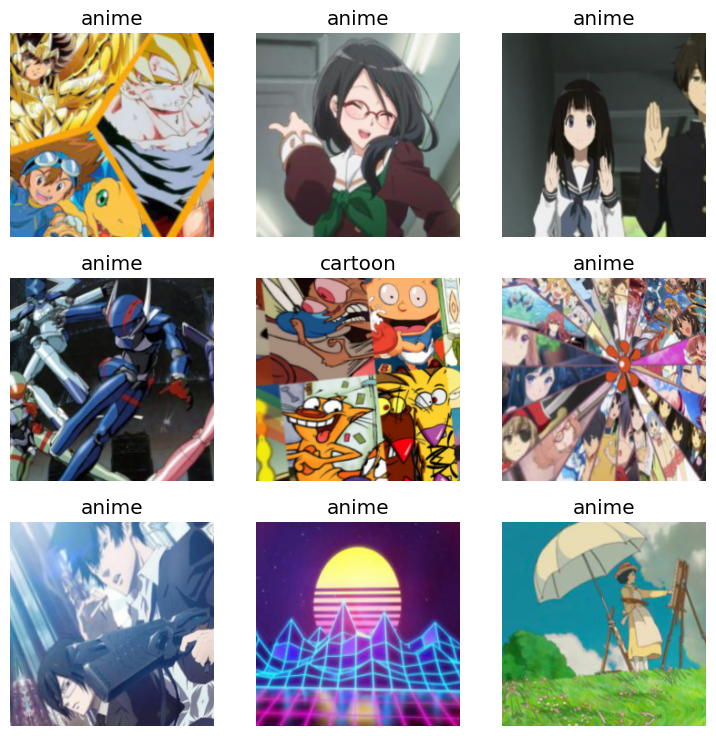

In [112]:
# Check a batch of images from data loaders
show_train = True

if show_train:
    print("Train")
    dls.train.show_batch()
else:
    print("Validation")
    dls.valid.show_batch()

## Step 3: Train your model

In [113]:
%%time
# Use restnet18 pre-trained model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/kinwaing/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.067516,0.710254,0.307692,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.500907,0.547105,0.230769,00:42
1,0.497666,0.469604,0.128205,00:36
2,0.358738,0.505751,0.102564,00:39
3,0.277444,0.428457,0.102564,00:36
4,0.216813,0.383685,0.102564,00:33


CPU times: user 3min 3s, sys: 11.5 s, total: 3min 15s
Wall time: 3min 38s


#### Check confusion matrix

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


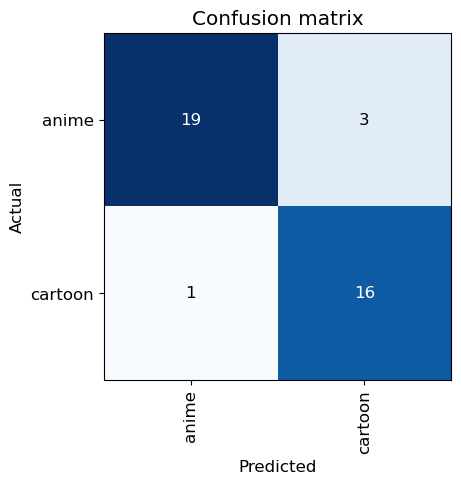

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Check the top losses (the images in which our model struggled the most)

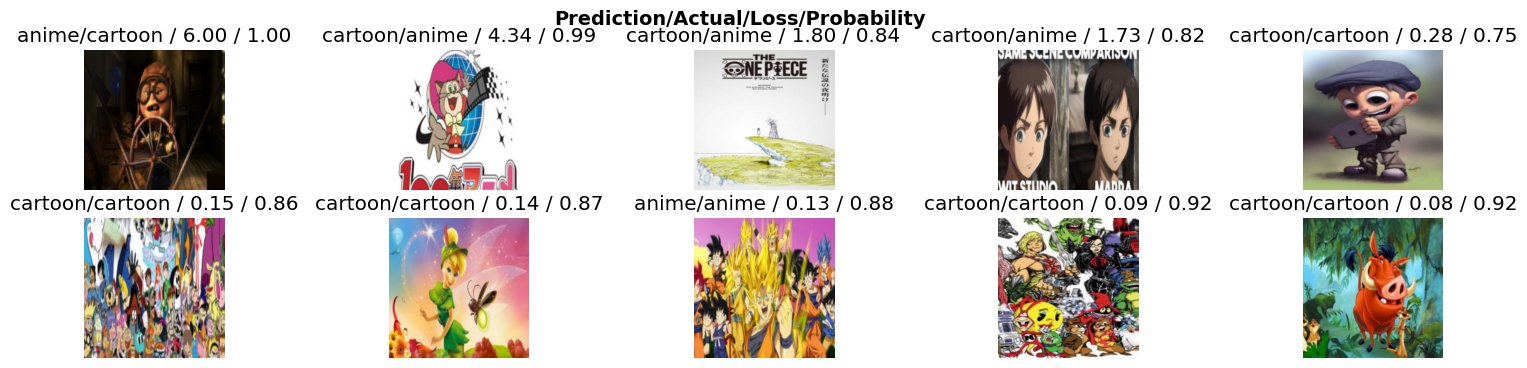

In [117]:
interp.plot_top_losses(10, nrows=2, figsize=(19,4))

#### Cleaning our dataset (relabeling) -- only for information purposes but not used in this project (there is an error for displaying)

In [119]:
from fastai.vision.widgets import *

In [122]:
cleaner = ImageClassifierCleaner(learn) # pass model
cleaner

In [123]:
# Once misclassifications are identified run the following code

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path_to_all_imgs/cat)

## Step 4: Save your model (It said that this steps requires a GPU)

In [6]:
# learn.export('../saved_models/model_anime_or_not.pkl')

## Step 5: Use model to make predictions

Important: if anything referenced by the Learner contains custom code not found in fast.ai library then that code needs to be imported or replicated in the inference environment

Useful [Link](https://benjaminwarner.dev/2021/10/01/inference-with-fastai) describing how to perform inference with fast.ai

In [7]:
trained_learn = load_learner("../saved_models/model_anime_or_not.pkl")

#### Load test images

In [8]:
def get_images_for_testing(path):

    imgs = glob.glob(path)
    imgs = [(img, img.split("/")[-2]) for img in imgs]
    return imgs

In [9]:
path = "../data/test_anime_or_not/*/*"
test_imgs = get_images_for_testing(path)

In [12]:
trained_learn.predict(PILImage.create("../data/test_anime_or_not/anime/0_SIEGcZ9zkBA5kTiU.png"))

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('anime', tensor(0), tensor([9.9934e-01, 6.5929e-04]))

#### Define a function to predict and store information in a dataframe

In [ ]:
import pandas as pd

In [16]:
def classify_image(tupl):
    global trained_learn # loaded classifier
    
    # create an image object
    gt = tupl[1]
    im = PILImage.create(tupl[0])

    pred, idx, probs = trained_learn.predict(im)
    row = [tupl[0], gt, pred] + list(map(float, probs))
    return row

def classify_images(imgs):
    header = ["image_id", "gt", "pred", "prob_anime", "prob_cartoon"]
    rows = []
    for im in imgs:
        row =  classify_image(im)
        rows.append(row)

    return pd.DataFrame(rows, columns=header)

In [19]:
%%time
df = classify_images(test_imgs)

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


CPU times: user 2.25 s, sys: 104 ms, total: 2.36 s
Wall time: 5.21 s


Image: ../data/test_anime_or_not/cartoon/Adventure-Time-Ice-King.jpg
GT: cartoon. Pred: anime. Prob Anime: 0.979. Prob Cartoon: 0.021


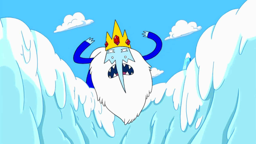

--------------------------------------------------
Image: ../data/test_anime_or_not/cartoon/best-nickelodeon-cartoons-1663103750.jpg
GT: cartoon. Pred: anime. Prob Anime: 0.749. Prob Cartoon: 0.251


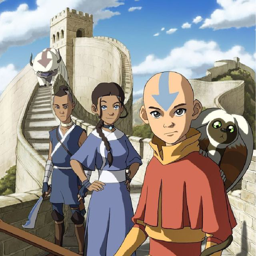

--------------------------------------------------
Image: ../data/test_anime_or_not/cartoon/MV5BNDQzMmRkOGEtMGM0Mi00OWUwLTgxOGUtZGY0M2JhNTc0YmRjXkEyXkFqcGdeQXVyNzU1NzE3NTg@._V1_QL75_UX500_CR0,47,500,281_.jpg
GT: cartoon. Pred: anime. Prob Anime: 0.839. Prob Cartoon: 0.161


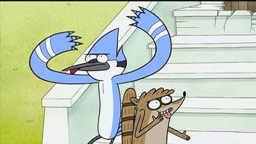

--------------------------------------------------
Image: ../data/test_anime_or_not/cartoon/Terrence.png
GT: cartoon. Pred: anime. Prob Anime: 0.811. Prob Cartoon: 0.189


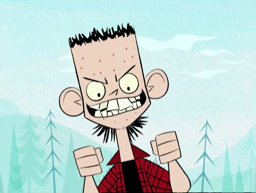

--------------------------------------------------
Image: ../data/test_anime_or_not/cartoon/_102977671_lingandpo.jpg
GT: cartoon. Pred: anime. Prob Anime: 0.644. Prob Cartoon: 0.356


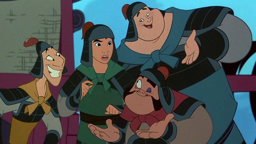

--------------------------------------------------


In [36]:
for row in df.loc[df['gt']!=df['pred']].itertuples():
    print(f"Image: {row.image_id}")
    print(f"GT: {row.gt}. Pred: {row.pred}. Prob Anime: {row.prob_anime:.3f}. Prob Cartoon: {row.prob_cartoon:.3f}")
    im = Image.open(row.image_id) # open path to img
    im = im.convert('RGB') # convert images to JPEG
    im.to_thumb(256,256).show()
    print("-"*50)

In [44]:
acc = (df['gt'] == df['pred']).sum()/len(df)

In [45]:
acc

0.75